In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import accuracy_score
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer
import nltk
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

# Load and clean Data

In [2]:
df = pd.read_csv('twitter_data(all).csv')
df.head()

,Date,ID,Name,Text,Hashtags,User Mentions,Symbols,Media,Source,Location,Follower count,Friends count,Favorite count,Retweet count,Status count,Industries
0,2021-03-22 10:46:46,1373949268164153345,YouTube,@StarlightWarm and beautiful 🌹,NaN,Don't touch my tea,NaN,NaN,Twitter Web App,"San Bruno, CA",73105218.0,1202.0,0.0,0.0,32085.0,Tech Company
1,2021-03-22 10:46:32,1373949209187995652,YouTube,@TheeAngryWalnut Spreading love everywhere!,NaN,😤 THEE ANGRY WALNUT IS HERE😤,NaN,NaN,Twitter Web App,"San Bruno, CA",73105218.0,1202.0,2.0,0.0,32085.0,Tech Company
2,2021-03-22 10:46:05,1373949093886582784,YouTube,@Maeliosa8 💕💕,NaN,Maeliosa,NaN,NaN,Twitter Web App,"San Bruno, CA",73105218.0,1202.0,0.0,0.0,32085.0,Tech Company
3,2021-03-22 06:00:04,1373877114743705602,YouTube,💞 The adventures of Natsumi and Haru! These si...,NaN,NaN,NaN,NaN,Sprinklr,"San Bruno, CA",73105218.0,1202.0,1400.0,99.0,32085.0,Tech Company
4,2021-03-21 19:38:33,1373720706689638401,YouTube,@LindseyMarsland Relatable https://t.co/FaSUCg...,NaN,Lindsey Marsland (she/her),NaN,http://pbs.twimg.com/tweet_video_thumb/ExBvsHI...,Twitter Web App,"San Bruno, CA",73105218.0,1202.0,3.0,0.0,32085.0,Tech Company


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['ID'] = df['ID'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16086 entries, 0 to 16085
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            16086 non-null  datetime64[ns]
 1   ID              16086 non-null  object        
 2   Name            16086 non-null  object        
 3   Text            16086 non-null  object        
 4   Hashtags        3474 non-null   object        
 5   User Mentions   8378 non-null   object        
 6   Symbols         15 non-null     object        
 7   Media           2643 non-null   object        
 8   Source          16086 non-null  object        
 9   Location        11390 non-null  object        
 10  Follower count  16086 non-null  float64       
 11  Friends count   16086 non-null  float64       
 12  Favorite count  16086 non-null  float64       
 13  Retweet count   16086 non-null  float64       
 14  Status count    16086 non-null  float64       
 15  In

In [4]:
# Filter out reply tweets
data = df.loc[~((df.Text.str.match('@.+\s')) & (df['Favorite count'] < 10) & (df['Retweet count'] < 10))]
data.reset_index(inplace=True, drop=True)
data

,Date,ID,Name,Text,Hashtags,User Mentions,Symbols,Media,Source,Location,Follower count,Friends count,Favorite count,Retweet count,Status count,Industries
0,2021-03-22 06:00:04,1373877114743705602,YouTube,💞 The adventures of Natsumi and Haru! These si...,NaN,NaN,NaN,NaN,Sprinklr,"San Bruno, CA",73105218.0,1202.0,1400.0,99.0,32085.0,Tech Company
1,2021-03-21 13:55:36,1373634398919262210,YouTube,"@MKBHD 10/10, would sign up again 🏆",NaN,Marques Brownlee,NaN,NaN,Twitter Web App,"San Bruno, CA",73105218.0,1202.0,6888.0,43.0,32085.0,Tech Company
2,2021-03-21 11:00:01,1373590213818212352,YouTube,💗Chocolate 💗\n 💗 Cappuccino 💗\n 💗C...,NaN,NaN,NaN,NaN,Sprinklr,"San Bruno, CA",73105218.0,1202.0,1584.0,128.0,32085.0,Tech Company
3,2021-03-20 23:54:48,1373422805199458305,YouTube,@OBB @ddlovato @Variety @decider @ratty @SB_Pr...,demiDWTD,"OBB,Demi Lovato,Variety,Decider,Michael D. Rat...",NaN,NaN,Twitter Web App,"San Bruno, CA",73105218.0,1202.0,71.0,18.0,32085.0,Tech Company
4,2021-03-20 23:31:40,1373416985439047681,YouTube,@VoytekPavlik https://t.co/WFAwYTuXoZ,NaN,Voytek Pavlik,NaN,http://pbs.twimg.com/tweet_video_thumb/Ew9bdXS...,Twitter Web App,"San Bruno, CA",73105218.0,1202.0,15.0,0.0,32085.0,Tech Company
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12596,2020-05-01 03:02:37,1256056403715735554,Gal Gadot,@LillyAspell @WonderWomanFilm @PattyJenks @DCC...,NaN,"Lilly Aspell,Wonder Woman 1984,Patty Jenkins,D...",NaN,NaN,Twitter for iPhone,NaN,2708999.0,169.0,1137.0,51.0,1758.0,Actor
12597,2020-05-01 02:32:38,1256048857625976834,Gal Gadot,@GDIGM Thank you legend!! Sending much love yo...,NaN,GeenaDavisInstitute,NaN,NaN,Twitter for iPhone,NaN,2708999.0,169.0,508.0,24.0,1758.0,Actor
12598,2020-05-01 02:31:38,1256048604088688640,Gal Gadot,@PattyJenks Jenkins !!!! I love you so much!! ...,NaN,Patty Jenkins,NaN,NaN,Twitter for iPhone,NaN,2708999.0,169.0,4947.0,325.0,1758.0,Actor
12599,2020-04-22 22:30:54,1253088919354134528,Gal Gadot,I’m so moved seeing everyones images of earth ...,earthday,NaN,NaN,NaN,Twitter for iPhone,NaN,2708999.0,169.0,17497.0,1175.0,1758.0,Actor


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12601 entries, 0 to 12600
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            12601 non-null  datetime64[ns]
 1   ID              12601 non-null  object        
 2   Name            12601 non-null  object        
 3   Text            12601 non-null  object        
 4   Hashtags        3361 non-null   object        
 5   User Mentions   4920 non-null   object        
 6   Symbols         8 non-null      object        
 7   Media           2561 non-null   object        
 8   Source          12601 non-null  object        
 9   Location        8600 non-null   object        
 10  Follower count  12601 non-null  float64       
 11  Friends count   12601 non-null  float64       
 12  Favorite count  12601 non-null  float64       
 13  Retweet count   12601 non-null  float64       
 14  Status count    12601 non-null  float64       
 15  In

In [6]:
data.describe()

,Follower count,Friends count,Favorite count,Retweet count,Status count
count,1.260100e+04,12601.000000,1.260100e+04,12601.000000,12601.000000
mean,3.104978e+07,40614.772796,2.085477e+04,3405.064201,87668.160622
std,3.305299e+07,109115.593097,9.134023e+04,17886.001187,136767.698340
min,2.900000e+01,0.000000,0.000000e+00,0.000000,2.000000
25%,4.933877e+06,130.000000,4.000000e+00,10.000000,10526.000000
50%,1.803052e+07,724.000000,3.100000e+02,97.000000,22643.000000
75%,5.187557e+07,12932.000000,4.936000e+03,1338.000000,87391.000000
max,1.300607e+08,593779.000000,4.212155e+06,810444.000000,667452.000000


<ipython-input-11-ba355f8f7bbe>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data.hist(ax = ax)


array([[<AxesSubplot:title={'center':'Follower count'}>,
        <AxesSubplot:title={'center':'Friends count'}>],
       [<AxesSubplot:title={'center':'Favorite count'}>,
        <AxesSubplot:title={'center':'Retweet count'}>],
       [<AxesSubplot:title={'center':'Status count'}>, <AxesSubplot:>]],
      dtype=object)

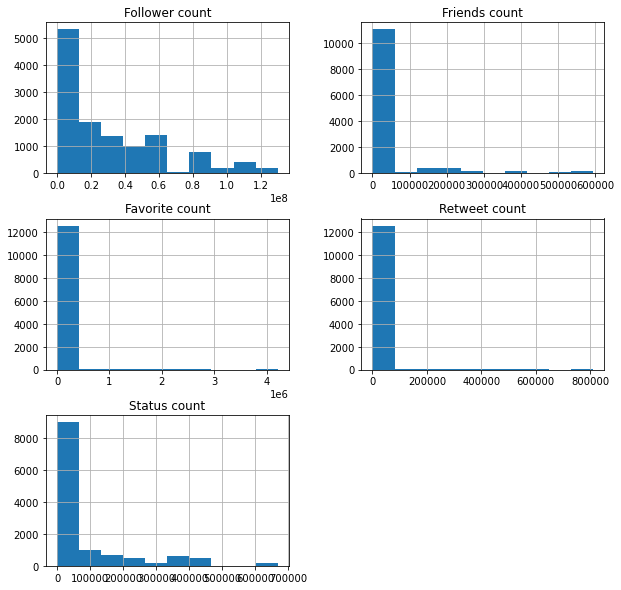

In [11]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
data.hist(ax = ax)

# Features Extraction

In [8]:
# Drop unnecessary columns
df1 = data.copy()
df1.drop(columns = ['Location', 'Source', 'Symbols', 'ID', 'Name'], inplace=True)
df1

,Date,Text,Hashtags,User Mentions,Media,Follower count,Friends count,Favorite count,Retweet count,Status count,Industries
0,2021-03-22 06:00:04,💞 The adventures of Natsumi and Haru! These si...,NaN,NaN,NaN,73105218.0,1202.0,1400.0,99.0,32085.0,Tech Company
1,2021-03-21 13:55:36,"@MKBHD 10/10, would sign up again 🏆",NaN,Marques Brownlee,NaN,73105218.0,1202.0,6888.0,43.0,32085.0,Tech Company
2,2021-03-21 11:00:01,💗Chocolate 💗\n 💗 Cappuccino 💗\n 💗C...,NaN,NaN,NaN,73105218.0,1202.0,1584.0,128.0,32085.0,Tech Company
3,2021-03-20 23:54:48,@OBB @ddlovato @Variety @decider @ratty @SB_Pr...,demiDWTD,"OBB,Demi Lovato,Variety,Decider,Michael D. Rat...",NaN,73105218.0,1202.0,71.0,18.0,32085.0,Tech Company
4,2021-03-20 23:31:40,@VoytekPavlik https://t.co/WFAwYTuXoZ,NaN,Voytek Pavlik,http://pbs.twimg.com/tweet_video_thumb/Ew9bdXS...,73105218.0,1202.0,15.0,0.0,32085.0,Tech Company
...,...,...,...,...,...,...,...,...,...,...,...
12596,2020-05-01 03:02:37,@LillyAspell @WonderWomanFilm @PattyJenks @DCC...,NaN,"Lilly Aspell,Wonder Woman 1984,Patty Jenkins,D...",NaN,2708999.0,169.0,1137.0,51.0,1758.0,Actor
12597,2020-05-01 02:32:38,@GDIGM Thank you legend!! Sending much love yo...,NaN,GeenaDavisInstitute,NaN,2708999.0,169.0,508.0,24.0,1758.0,Actor
12598,2020-05-01 02:31:38,@PattyJenks Jenkins !!!! I love you so much!! ...,NaN,Patty Jenkins,NaN,2708999.0,169.0,4947.0,325.0,1758.0,Actor
12599,2020-04-22 22:30:54,I’m so moved seeing everyones images of earth ...,earthday,NaN,NaN,2708999.0,169.0,17497.0,1175.0,1758.0,Actor


In [9]:
# Extract time and day of week from Date column

def greeting(hours):
    if hours in range(5,12):
        h = 'morning'
    elif hours in range(12,18):
        h = 'afternoon'
    elif hours in range(18,21):
        h = 'evening'
    else:
        h = 'night'
    return h

def name_the_day(day):
    if day == 0:
        return "Monday"
    elif day == 1:
        return "Tuesday"
    elif day == 2:
        return "Wednesday"
    elif day == 3:
        return "Thursday"
    elif day == 4:
        return "Friday"
    elif day == 5:
        return "Saturday"
    else:
        return "Sunday"
    

df1['Time'] = data['Date'].dt.hour.apply(greeting)
df1['Day of Weeks'] = data['Date'].dt.dayofweek.apply(name_the_day)
df1

,Date,Text,Hashtags,User Mentions,Media,Follower count,Friends count,Favorite count,Retweet count,Status count,Industries,Time,Day of Weeks
0,2021-03-22 06:00:04,💞 The adventures of Natsumi and Haru! These si...,NaN,NaN,NaN,73105218.0,1202.0,1400.0,99.0,32085.0,Tech Company,morning,Monday
1,2021-03-21 13:55:36,"@MKBHD 10/10, would sign up again 🏆",NaN,Marques Brownlee,NaN,73105218.0,1202.0,6888.0,43.0,32085.0,Tech Company,afternoon,Sunday
2,2021-03-21 11:00:01,💗Chocolate 💗\n 💗 Cappuccino 💗\n 💗C...,NaN,NaN,NaN,73105218.0,1202.0,1584.0,128.0,32085.0,Tech Company,morning,Sunday
3,2021-03-20 23:54:48,@OBB @ddlovato @Variety @decider @ratty @SB_Pr...,demiDWTD,"OBB,Demi Lovato,Variety,Decider,Michael D. Rat...",NaN,73105218.0,1202.0,71.0,18.0,32085.0,Tech Company,night,Saturday
4,2021-03-20 23:31:40,@VoytekPavlik https://t.co/WFAwYTuXoZ,NaN,Voytek Pavlik,http://pbs.twimg.com/tweet_video_thumb/Ew9bdXS...,73105218.0,1202.0,15.0,0.0,32085.0,Tech Company,night,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12596,2020-05-01 03:02:37,@LillyAspell @WonderWomanFilm @PattyJenks @DCC...,NaN,"Lilly Aspell,Wonder Woman 1984,Patty Jenkins,D...",NaN,2708999.0,169.0,1137.0,51.0,1758.0,Actor,night,Friday
12597,2020-05-01 02:32:38,@GDIGM Thank you legend!! Sending much love yo...,NaN,GeenaDavisInstitute,NaN,2708999.0,169.0,508.0,24.0,1758.0,Actor,night,Friday
12598,2020-05-01 02:31:38,@PattyJenks Jenkins !!!! I love you so much!! ...,NaN,Patty Jenkins,NaN,2708999.0,169.0,4947.0,325.0,1758.0,Actor,night,Friday
12599,2020-04-22 22:30:54,I’m so moved seeing everyones images of earth ...,earthday,NaN,NaN,2708999.0,169.0,17497.0,1175.0,1758.0,Actor,night,Wednesday


In [10]:
# Create Hashtag Count and length

def hashtags_count(hashs):
    if pd.notna(hashs) :
        hashs = str(hashs)
        hashs = hashs.split(',')
        counts = len(hashs)
    else:
        counts = 0
    return counts

def length_h(hashs):
    if pd.notna(hashs):
        hashs = str(hashs).replace(',','')
        count = len(list(hashs))
        return count
    else:
        return 0

df1['hashtags_count'] = df1.Hashtags.apply(hashtags_count)
df1['length_hashtag'] = df1.Hashtags.apply(length_h)

df1

,Date,Text,Hashtags,User Mentions,Media,Follower count,Friends count,Favorite count,Retweet count,Status count,Industries,Time,Day of Weeks,hashtags_count,length_hashtag
0,2021-03-22 06:00:04,💞 The adventures of Natsumi and Haru! These si...,NaN,NaN,NaN,73105218.0,1202.0,1400.0,99.0,32085.0,Tech Company,morning,Monday,0,0
1,2021-03-21 13:55:36,"@MKBHD 10/10, would sign up again 🏆",NaN,Marques Brownlee,NaN,73105218.0,1202.0,6888.0,43.0,32085.0,Tech Company,afternoon,Sunday,0,0
2,2021-03-21 11:00:01,💗Chocolate 💗\n 💗 Cappuccino 💗\n 💗C...,NaN,NaN,NaN,73105218.0,1202.0,1584.0,128.0,32085.0,Tech Company,morning,Sunday,0,0
3,2021-03-20 23:54:48,@OBB @ddlovato @Variety @decider @ratty @SB_Pr...,demiDWTD,"OBB,Demi Lovato,Variety,Decider,Michael D. Rat...",NaN,73105218.0,1202.0,71.0,18.0,32085.0,Tech Company,night,Saturday,1,8
4,2021-03-20 23:31:40,@VoytekPavlik https://t.co/WFAwYTuXoZ,NaN,Voytek Pavlik,http://pbs.twimg.com/tweet_video_thumb/Ew9bdXS...,73105218.0,1202.0,15.0,0.0,32085.0,Tech Company,night,Saturday,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12596,2020-05-01 03:02:37,@LillyAspell @WonderWomanFilm @PattyJenks @DCC...,NaN,"Lilly Aspell,Wonder Woman 1984,Patty Jenkins,D...",NaN,2708999.0,169.0,1137.0,51.0,1758.0,Actor,night,Friday,0,0
12597,2020-05-01 02:32:38,@GDIGM Thank you legend!! Sending much love yo...,NaN,GeenaDavisInstitute,NaN,2708999.0,169.0,508.0,24.0,1758.0,Actor,night,Friday,0,0
12598,2020-05-01 02:31:38,@PattyJenks Jenkins !!!! I love you so much!! ...,NaN,Patty Jenkins,NaN,2708999.0,169.0,4947.0,325.0,1758.0,Actor,night,Friday,0,0
12599,2020-04-22 22:30:54,I’m so moved seeing everyones images of earth ...,earthday,NaN,NaN,2708999.0,169.0,17497.0,1175.0,1758.0,Actor,night,Wednesday,1,8


In [11]:
# Create user_mention Count

def mention_count(x):
    if pd.notna(x):
        x = str(x)
        x = x.split(',')
        counts = len(x)
    else:
        counts = 0
    return counts

df1['user_mentions_count'] = df1['User Mentions'].apply(mention_count)
df1

,Date,Text,Hashtags,User Mentions,Media,Follower count,Friends count,Favorite count,Retweet count,Status count,Industries,Time,Day of Weeks,hashtags_count,length_hashtag,user_mentions_count
0,2021-03-22 06:00:04,💞 The adventures of Natsumi and Haru! These si...,NaN,NaN,NaN,73105218.0,1202.0,1400.0,99.0,32085.0,Tech Company,morning,Monday,0,0,0
1,2021-03-21 13:55:36,"@MKBHD 10/10, would sign up again 🏆",NaN,Marques Brownlee,NaN,73105218.0,1202.0,6888.0,43.0,32085.0,Tech Company,afternoon,Sunday,0,0,1
2,2021-03-21 11:00:01,💗Chocolate 💗\n 💗 Cappuccino 💗\n 💗C...,NaN,NaN,NaN,73105218.0,1202.0,1584.0,128.0,32085.0,Tech Company,morning,Sunday,0,0,0
3,2021-03-20 23:54:48,@OBB @ddlovato @Variety @decider @ratty @SB_Pr...,demiDWTD,"OBB,Demi Lovato,Variety,Decider,Michael D. Rat...",NaN,73105218.0,1202.0,71.0,18.0,32085.0,Tech Company,night,Saturday,1,8,6
4,2021-03-20 23:31:40,@VoytekPavlik https://t.co/WFAwYTuXoZ,NaN,Voytek Pavlik,http://pbs.twimg.com/tweet_video_thumb/Ew9bdXS...,73105218.0,1202.0,15.0,0.0,32085.0,Tech Company,night,Saturday,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12596,2020-05-01 03:02:37,@LillyAspell @WonderWomanFilm @PattyJenks @DCC...,NaN,"Lilly Aspell,Wonder Woman 1984,Patty Jenkins,D...",NaN,2708999.0,169.0,1137.0,51.0,1758.0,Actor,night,Friday,0,0,5
12597,2020-05-01 02:32:38,@GDIGM Thank you legend!! Sending much love yo...,NaN,GeenaDavisInstitute,NaN,2708999.0,169.0,508.0,24.0,1758.0,Actor,night,Friday,0,0,1
12598,2020-05-01 02:31:38,@PattyJenks Jenkins !!!! I love you so much!! ...,NaN,Patty Jenkins,NaN,2708999.0,169.0,4947.0,325.0,1758.0,Actor,night,Friday,0,0,1
12599,2020-04-22 22:30:54,I’m so moved seeing everyones images of earth ...,earthday,NaN,NaN,2708999.0,169.0,17497.0,1175.0,1758.0,Actor,night,Wednesday,1,8,0


In [12]:
# Dummy if media exist
def media_dummy(x):
    if pd.notna(x):
        return 1
    else:
        return 0

df1['media_dummy'] = df1['Media'].apply(media_dummy)
df1

,Date,Text,Hashtags,User Mentions,Media,Follower count,Friends count,Favorite count,Retweet count,Status count,Industries,Time,Day of Weeks,hashtags_count,length_hashtag,user_mentions_count,media_dummy
0,2021-03-22 06:00:04,💞 The adventures of Natsumi and Haru! These si...,NaN,NaN,NaN,73105218.0,1202.0,1400.0,99.0,32085.0,Tech Company,morning,Monday,0,0,0,0
1,2021-03-21 13:55:36,"@MKBHD 10/10, would sign up again 🏆",NaN,Marques Brownlee,NaN,73105218.0,1202.0,6888.0,43.0,32085.0,Tech Company,afternoon,Sunday,0,0,1,0
2,2021-03-21 11:00:01,💗Chocolate 💗\n 💗 Cappuccino 💗\n 💗C...,NaN,NaN,NaN,73105218.0,1202.0,1584.0,128.0,32085.0,Tech Company,morning,Sunday,0,0,0,0
3,2021-03-20 23:54:48,@OBB @ddlovato @Variety @decider @ratty @SB_Pr...,demiDWTD,"OBB,Demi Lovato,Variety,Decider,Michael D. Rat...",NaN,73105218.0,1202.0,71.0,18.0,32085.0,Tech Company,night,Saturday,1,8,6,0
4,2021-03-20 23:31:40,@VoytekPavlik https://t.co/WFAwYTuXoZ,NaN,Voytek Pavlik,http://pbs.twimg.com/tweet_video_thumb/Ew9bdXS...,73105218.0,1202.0,15.0,0.0,32085.0,Tech Company,night,Saturday,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12596,2020-05-01 03:02:37,@LillyAspell @WonderWomanFilm @PattyJenks @DCC...,NaN,"Lilly Aspell,Wonder Woman 1984,Patty Jenkins,D...",NaN,2708999.0,169.0,1137.0,51.0,1758.0,Actor,night,Friday,0,0,5,0
12597,2020-05-01 02:32:38,@GDIGM Thank you legend!! Sending much love yo...,NaN,GeenaDavisInstitute,NaN,2708999.0,169.0,508.0,24.0,1758.0,Actor,night,Friday,0,0,1,0
12598,2020-05-01 02:31:38,@PattyJenks Jenkins !!!! I love you so much!! ...,NaN,Patty Jenkins,NaN,2708999.0,169.0,4947.0,325.0,1758.0,Actor,night,Friday,0,0,1,0
12599,2020-04-22 22:30:54,I’m so moved seeing everyones images of earth ...,earthday,NaN,NaN,2708999.0,169.0,17497.0,1175.0,1758.0,Actor,night,Wednesday,1,8,0,0


In [13]:
# Dummy Industries, Time and Day of Weeks
df1 = pd.get_dummies(df1, columns=['Industries', 'Time', 'Day of Weeks'])
df1

,Date,Text,Hashtags,User Mentions,Media,Follower count,Friends count,Favorite count,Retweet count,Status count,...,Time_evening,Time_morning,Time_night,Day of Weeks_Friday,Day of Weeks_Monday,Day of Weeks_Saturday,Day of Weeks_Sunday,Day of Weeks_Thursday,Day of Weeks_Tuesday,Day of Weeks_Wednesday
0,2021-03-22 06:00:04,💞 The adventures of Natsumi and Haru! These si...,NaN,NaN,NaN,73105218.0,1202.0,1400.0,99.0,32085.0,...,0,1,0,0,1,0,0,0,0,0
1,2021-03-21 13:55:36,"@MKBHD 10/10, would sign up again 🏆",NaN,Marques Brownlee,NaN,73105218.0,1202.0,6888.0,43.0,32085.0,...,0,0,0,0,0,0,1,0,0,0
2,2021-03-21 11:00:01,💗Chocolate 💗\n 💗 Cappuccino 💗\n 💗C...,NaN,NaN,NaN,73105218.0,1202.0,1584.0,128.0,32085.0,...,0,1,0,0,0,0,1,0,0,0
3,2021-03-20 23:54:48,@OBB @ddlovato @Variety @decider @ratty @SB_Pr...,demiDWTD,"OBB,Demi Lovato,Variety,Decider,Michael D. Rat...",NaN,73105218.0,1202.0,71.0,18.0,32085.0,...,0,0,1,0,0,1,0,0,0,0
4,2021-03-20 23:31:40,@VoytekPavlik https://t.co/WFAwYTuXoZ,NaN,Voytek Pavlik,http://pbs.twimg.com/tweet_video_thumb/Ew9bdXS...,73105218.0,1202.0,15.0,0.0,32085.0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12596,2020-05-01 03:02:37,@LillyAspell @WonderWomanFilm @PattyJenks @DCC...,NaN,"Lilly Aspell,Wonder Woman 1984,Patty Jenkins,D...",NaN,2708999.0,169.0,1137.0,51.0,1758.0,...,0,0,1,1,0,0,0,0,0,0
12597,2020-05-01 02:32:38,@GDIGM Thank you legend!! Sending much love yo...,NaN,GeenaDavisInstitute,NaN,2708999.0,169.0,508.0,24.0,1758.0,...,0,0,1,1,0,0,0,0,0,0
12598,2020-05-01 02:31:38,@PattyJenks Jenkins !!!! I love you so much!! ...,NaN,Patty Jenkins,NaN,2708999.0,169.0,4947.0,325.0,1758.0,...,0,0,1,1,0,0,0,0,0,0
12599,2020-04-22 22:30:54,I’m so moved seeing everyones images of earth ...,earthday,NaN,NaN,2708999.0,169.0,17497.0,1175.0,1758.0,...,0,0,1,0,0,0,0,0,0,1


In [14]:
# Vectorize the text using CountVectorizer

countVect = CountVectorizer()

def getWordnetPos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else: 
        return None
    
myStopwords = stopwords.words('english')
myStopwords.append('would')
myStopwords.append('thing')
myStopwords.append('want')
myStopwords.append('thanks')
myStopwords.append('https')
myStopwords.append('every')
myStopwords.append('re')
myStopwords.append('the')
myStopwords.append('co')

lemmatizer = WordNetLemmatizer()
corpus = list()

for text in df1['Text']:
    
    tweetText = text.lower()
    tweetText = tweetText.replace('\n', ' ')
    tweetText = re.sub(r'[^\x00-\x7F]','',tweetText) #Remove Non-ASCII Charactors (i.e. emoji and etc.)
    tweetText = re.sub(r'[(,),!]','',tweetText)

    wordLem = list()
    sentences = sent_tokenize(tweetText)
    for sentence in sentences:
        words = word_tokenize(sentence)
        wordPos = nltk.pos_tag(words)
        for w,p in wordPos:
            wntag = getWordnetPos(p)
            if wntag is None:
                wordLem.append(lemmatizer.lemmatize(w))
            else:
                wordLem.append(lemmatizer.lemmatize(w, pos=wntag))
        
    wordLem = [w for w in wordLem if len(w) > 2]
    wordLem = [w for w in wordLem if w not in myStopwords]
    
    wordSentenceLem = ' '.join(wordLem)
    corpus.append(wordSentenceLem)
    
countVect = CountVectorizer(max_features=100)
cvCorpus = countVect.fit_transform(corpus)

textFeatures = pd.DataFrame(cvCorpus.toarray(), columns=countVect.get_feature_names())
textFeatures

,19,2020,2021,always,american,americanidol,amp,back,best,big,...,vote,watch,way,wear,week,win,woman,work,world,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12597,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12599,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
textFeatures.columns

Index(['19', '2020', '2021', 'always', 'american', 'americanidol', 'amp',
       'back', 'best', 'big', 'brand', 'business', 'call', 'celebrate',
       'chanel', 'change', 'check', 'city', 'co', 'collection', 'come',
       'content', 'covid', 'create', 'day', 'dont', 'ever', 'facebook',
       'feature', 'find', 'first', 'free', 'friend', 'get', 'give', 'good',
       'great', 'happy', 'help', 'house', 'http', 'join', 'know', 'last',
       'late', 'let', 'life', 'like', 'listen', 'live', 'look', 'love', 'make',
       'many', 'marketing', 'medium', 'million', 'much', 'need', 'new', 'one',
       'people', 'photograph', 'plan', 'podcast', 'potus', 'president', 're',
       'right', 'say', 'see', 'share', 'show', 'social', 'start', 'state',
       'story', 'style', 'take', 'talk', 'tell', 'thank', 'think', 'time',
       'today', 'tonight', 'two', 'use', 'vaccine', 'video', 'vote', 'watch',
       'way', 'wear', 'week', 'win', 'woman', 'work', 'world', 'year'],
      dtype='object')

In [16]:
# Concate text feature to the df1

df_model = pd.concat([df1.drop(columns=['Date', 'Text', 'Hashtags', 'User Mentions', 'Media']), textFeatures], axis=1)
df_model

,Follower count,Friends count,Favorite count,Retweet count,Status count,hashtags_count,length_hashtag,user_mentions_count,media_dummy,Industries_Actor,...,vote,watch,way,wear,week,win,woman,work,world,year
0,73105218.0,1202.0,1400.0,99.0,32085.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,73105218.0,1202.0,6888.0,43.0,32085.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,73105218.0,1202.0,1584.0,128.0,32085.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,73105218.0,1202.0,71.0,18.0,32085.0,1,8,6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,73105218.0,1202.0,15.0,0.0,32085.0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12596,2708999.0,169.0,1137.0,51.0,1758.0,0,0,5,0,1,...,0,0,0,0,0,0,0,0,0,0
12597,2708999.0,169.0,508.0,24.0,1758.0,0,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
12598,2708999.0,169.0,4947.0,325.0,1758.0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
12599,2708999.0,169.0,17497.0,1175.0,1758.0,1,8,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12601 entries, 0 to 12600
Columns: 127 entries, Follower count to year
dtypes: float64(5), int64(104), uint8(18)
memory usage: 10.7 MB


In [18]:
# Model Building 

y = df_model['Retweet count']
X = df_model.drop(columns=['Retweet count', 'Industries_Non-tech Company', 'Time_morning', 'Day of Weeks_Monday', 'Favorite count'])

# Create train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=53, test_size=0.2)

model = LinearRegression()
model.fit(X_train,y_train)

r_sq = model.score(X_test, y_test)
print('Test set r_sqr:', r_sq)

Test set r_sqr: 0.0708484622123956


In [19]:
# Model Building 

y = df_model['Retweet count']
X = df1.drop(columns=['Date', 'Text', 'Hashtags', 'User Mentions', 'Media','Retweet count', 'Industries_Non-tech Company', 'Time_morning', 'Day of Weeks_Monday', 'Favorite count'])

# Create train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=53, test_size=0.2)

model = LinearRegression()
model.fit(X_train,y_train)

r_sq = model.score(X_test, y_test)
print('Test set r_sqr:', r_sq)

Test set r_sqr: 0.06916193783463609


In [20]:
# Model Building
y = df_model['Retweet count']
X = df_model.drop(columns=['Retweet count', 'Industries_Non-tech Company', 'Time_morning', 'Day of Weeks_Monday', 'Favorite count'])

# Create train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=53, test_size=0.2)

model = sm.OLS(y_train, X_train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Retweet count   R-squared (uncentered):                   0.110
Model:                            OLS   Adj. R-squared (uncentered):              0.099
Method:                 Least Squares   F-statistic:                              10.08
Date:                Sat, 27 Mar 2021   Prob (F-statistic):                   5.45e-170
Time:                        18:57:24   Log-Likelihood:                     -1.1272e+05
No. Observations:               10080   AIC:                                  2.257e+05
Df Residuals:                    9958   BIC:                                  2.266e+05
Df Model:                         122                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Follower count           5.318e-05   1.01e-05      5.289      0.000    3.35e-05    7.29e-05
Friends count              -0.0079      0.002     -3.870      0.000      -0.012      -0.004
Status count            -4.162e-05      0.002     -0.021      0.983      -0.004       0.004
hashtags_count           -623.5525    698.505     -0.893      0.372   -1992.764     745.659
length_hashtag             -5.0251     60.767     -0.083      0.934    -124.141     114.091
user_mentions_count     -1095.1803    215.439     -5.083      0.000   -1517.484    -672.876
media_dummy              3531.8133    530.245      6.661      0.000    2492.425    4571.201
Industries_Actor         2351.1779    742.217      3.168      0.002     896.282    3806.074
Industries_Influencer    1765.1345    705.641      2.501      0.012     381.936    3148.333
Industries_News         -1856.3665    972.725     -1.908      0.056   -3763.104      50.371
Industries_Politician    1.013e+04    952.369     10.631      0.000    8258.273     1.2e+04
Industries_Singer        7411.4988   1012.624      7.319      0.000    5426.551    9396.446
Industries_Tech Company  -180.1181    852.060     -0.211      0.833   -1850.329    1490.093
Time_afternoon           1381.0674    548.487      2.518      0.012     305.923    2456.212
Time_evening              415.1618    623.893      0.665      0.506    -807.794    1638.118
Time_night                -68.2312    584.992     -0.117      0.907   -1214.934    1078.472
Day of Weeks_Friday       209.4861    587.081      0.357      0.721    -941.311    1360.283
Day of Weeks_Saturday    1776.4386    647.004      2.746      0.006     508.180    3044.697
Day of Weeks_Sunday      1573.2069    649.760      2.421      0.015     299.545    2846.869
Day of Weeks_Thursday     865.6177    611.761      1.415      0.157    -333.558    2064.793
Day of Weeks_Tuesday      -60.4201    633.512     -0.095      0.924   -1302.231    1181.391
Day of Weeks_Wednesday    695.1961    614.399      1.132      0.258    -509.151    1899.543
19                      -2571.8138   2439.402     -1.054      0.292   -7353.535    2209.907
2020                      152.5049   1572.576      0.097      0.923   -2930.062    3235.071
2021                     -343.1693   1360.076     -0.252      0.801   -3009.193    2322.855
always                  -1044.7097   1617.316     -0.646      0.518   -4214.976    2125.557
american                  786.7712   1476.365      0.533      0.594   -2107.202    3680.744
americanidol            -1.287e+04   1794.337     -7.171      0.000   -1.64e+04   -9349.467
amp                       517.9432    834.107      0.621      0.535   -1117.076    2152.963
back                       11.3153   138

In [21]:
# Model Building

y = df_model['Retweet count']
X = df1.drop(columns=['Date', 'Text', 'Hashtags', 'User Mentions', 'Media','Retweet count', 'Industries_Non-tech Company', 'Time_morning', 'Day of Weeks_Monday', 'Favorite count'])

# Create train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=53, test_size=0.2)

model = sm.OLS(y_train, X_train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Retweet count   R-squared (uncentered):                   0.095
Model:                            OLS   Adj. R-squared (uncentered):              0.093
Method:                 Least Squares   F-statistic:                              47.84
Date:                Sat, 27 Mar 2021   Prob (F-statistic):                   7.29e-198
Time:                        18:57:24   Log-Likelihood:                     -1.1281e+05
No. Observations:               10080   AIC:                                  2.257e+05
Df Residuals:                   10058   BIC:                                  2.258e+05
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Follower count           3.894e-05   9.68e-06      4.024      0.000       2e-05    5.79e-05
Friends count              -0.0053      0.002     -2.710      0.007      -0.009      -0.001
Status count               -0.0020      0.002     -1.081      0.280      -0.006       0.002
hashtags_count           -507.7543    694.889     -0.731      0.465   -1869.875     854.366
length_hashtag            -46.7286     60.479     -0.773      0.440    -165.279      71.821
user_mentions_count      -740.0614    203.887     -3.630      0.000   -1139.720    -340.403
media_dummy              2267.5995    458.887      4.942      0.000    1368.089    3167.110
Industries_Actor         2237.3453    671.570      3.332      0.001     920.934    3553.757
Industries_Influencer     723.7625    614.389      1.178      0.239    -480.563    1928.088
Industries_News         -1729.4444    897.530     -1.927      0.054   -3488.782      29.893
Industries_Politician    1.015e+04    827.012     12.276      0.000    8531.428    1.18e+04
Industries_Singer        6750.8782    950.051      7.106      0.000    4888.588    8613.169
Industries_Tech Company  -246.8799    800.026     -0.309      0.758   -1815.091    1321.331
Time_afternoon            703.5438    508.880      1.383      0.167    -293.962    1701.049
Time_evening              -73.6985    593.456     -0.124      0.901   -1236.992    1089.595
Time_night               -750.6945    553.609     -1.356      0.175   -1835.879     334.490
Day of Weeks_Friday       429.1239    560.410      0.766      0.444    -669.391    1527.639
Day of Weeks_Saturday    2020.1975    624.182      3.237      0.001     796.677    3243.718
Day of Weeks_Sunday      1688.5332    630.839      2.677      0.007     451.963    2925.103
Day of Weeks_Thursday    1299.4448    588.188      2.209      0.027     146.478    2452.412
Day of Weeks_Tuesday      323.9470    609.167      0.532      0.595    -870.143    1518.037
Day of Weeks_Wednesday   1066.8328    592.502      1.801      0.072     -94.589    2228.254
==============================================================================
Omnibus:                    23626.871   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        267352716.907
Skew:                          23.264   Prob(JB):                         0.00
Kurtosis:                     799.486   Cond. No.                     3.96e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.96e+08. This might indicate that there are
strong multicollinearity or

In [22]:
y = df_model['Retweet count']
X = df_model.drop(columns=['Retweet count', 'Industries_Non-tech Company', 'Time_morning', 'Day of Weeks_Monday', 'Favorite count'])

# Create train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=53, test_size=0.2)

model = LinearRegression()
model.fit(X_train,y_train)

r_sq = model.score(X_test, y_test)
print('Test set r_sqr:', r_sq)

Test set r_sqr: 0.0708484622123956


In [23]:
# Model building using regularization
def computeCostReg(X, y, theta, lambda_ = 0):
    # initialize some useful values
    m = y.size  # number of training examples
    J = 0
    h = np.dot(X, theta)
    J = (1/(m)) * np.sum(np.square(h - y))+(lambda_ / m) *np.sum(np.square(theta[1:]))
    return J

def gradientDescentReg(X, y, theta, alpha, num_iters , lambda_=0):
    m = y.shape[0]  # number of training examples
    theta = theta.copy()
    J_history = [] # Use a python list to save cost in every iteration
    for i in range(num_iters):
        tmp = theta.copy()
        tmp[0] = 0
        theta = theta - (alpha / m) * ((np.dot(X, theta) - y).dot(X) + lambda_*tmp)
        J_history.append(computeCostReg(X, y, theta, lambda_))
    return theta, J_history

def learningCurve(X, y, Xval, yval, theta, alpha, iterations, lambda_=0):
    # Number of training examples
    m = y.size
    error_train = np.zeros(m)
    error_val   = np.zeros(m)

    for i in range(1, m + 1):
        theta_t, _ = gradientDescentReg(X[:i], y[:i], theta, alpha, iterations, lambda_)
        error_train[i-1] = computeCostReg(X[:i], y[:i], theta_t, lambda_=0)
        error_val[i-1] = computeCostReg(Xval, yval, theta_t, lambda_=0)        
    return error_train, error_val

def validationCurve(X, y, Xval, yval, theta, alpha, iterations):
    # Selected values of lambda (you should not change this)
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

    # You need to return these variables correctly.
    error_train = np.zeros(len(lambda_vec))
    error_val = np.zeros(len(lambda_vec))

    for i in range(len(lambda_vec)):
        lambda_try = lambda_vec[i]
        theta_t, _ = gradientDescentReg(X, y, theta, alpha, iterations, lambda_try)
        error_train[i] = computeCostReg(X, y, theta_t, lambda_ = 0)
        error_val[i] = computeCostReg(Xval, yval, theta_t, lambda_ = 0)
        
    return lambda_vec, error_train, error_val

# mean normalization
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])
    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma
       
    return X_norm, mu, sigma

In [24]:
# Model Building

# get train-test-validation sets
X_norm, mu, sigma = featureNormalize(X.to_numpy())

X_train, X_test, y_train, y_test = train_test_split(X_norm, y.to_numpy(), random_state=53, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
m = y_train.size # training examples
n = X_train.shape[1] # input features

# Vectorize
X_train = np.concatenate([np.ones((y_train.size, 1)), X_train], axis=1)
X_val = np.concatenate([np.ones((y_val.size, 1)), X_val], axis=1)
X_test = np.concatenate([np.ones((y_test.size, 1)), X_test], axis=1)

In [25]:
# initialize fitting parameters

lambda_ = 0
theta = np.zeros(n+1)
iterations = 10000
alpha = 0.01

theta, J_history = gradientDescentReg(X_train, y_train, theta, alpha, iterations, lambda_)

from sklearn.metrics import r2_score

#test set
print("test set accuracy")
print("average cost", np.sqrt(J_history[len(J_history)-1]))

#correlation
predict_t = np.dot(X_test, theta)
print(np.corrcoef(y_test,predict_t))

#r-squared
print("R squared: ", r2_score(y_test,predict_t))

test set accuracy
average cost 17031.769358319507
[[1.         0.26796491]
 [0.26796491 1.        ]]
R squared:  0.07023373179056958


Text(0, 0.5, 'Error')

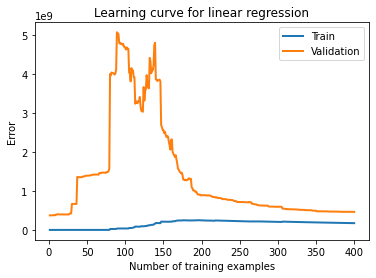

In [26]:
# initialize fitting parameters

lambda_ = 0
theta = np.zeros(n+1)
iterations = 10000
alpha = 0.01

def learningCurve(X, y, Xval, yval, theta, alpha, iterations, lambda_=0):
    # Number of training examples
    #m = y.size
    m = 400
    error_train = np.zeros(m)
    error_val   = np.zeros(m)

    for i in range(1, m + 1):
        theta_t, _ = gradientDescentReg(X[:i], y[:i], theta, alpha, iterations, lambda_)
        error_train[i-1] = computeCostReg(X[:i], y[:i], theta_t, lambda_=0)
        error_val[i-1] = computeCostReg(Xval, yval, theta_t, lambda_=0)        
    return error_train, error_val

error_train, error_val = learningCurve(X_train, y_train, X_val, y_val, theta, alpha, iterations)

m = 400
plt.plot(np.arange(1, m+1), error_train, lw=2)
plt.plot(np.arange(1, m+1), error_val, lw=2)
plt.title('Learning curve for linear regression')
plt.legend(['Train', 'Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')


# Overfitting

lambda		Train Error	Validation Error
 0.000000	290081167.474991	341168514.793534
 100.000000	290091498.141872	341133412.498764
 200.000000	290117932.834408	341108551.983157
 300.000000	290156110.429453	341092070.698153
 400.000000	290203350.271619	341082751.681458
 500.000000	290257813.022072	341079658.150514
 600.000000	290318145.938575	341082018.237912
 700.000000	290383309.053814	341089178.835238
 800.000000	290452478.822602	341100580.911070
 900.000000	290524989.305466	341115742.875551

 lambda with lowest validation cost: 500.000000


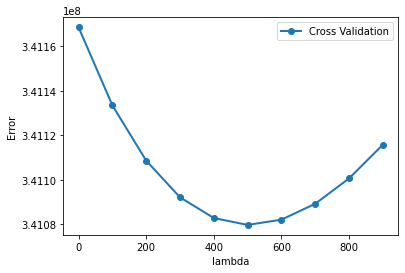

In [27]:
# Choosing lambda_ for regularization

def validationCurve(X, y, Xval, yval, theta, alpha, iterations):
    # Selected values of lambda (you should not change this)
    lambda_vec = list(range(0,1000,100))

    # You need to return these variables correctly.
    error_train = np.zeros(len(lambda_vec))
    error_val = np.zeros(len(lambda_vec))

    for i in range(len(lambda_vec)):
        lambda_try = lambda_vec[i]
        theta_t, _ = gradientDescentReg(X, y, theta, alpha, iterations, lambda_try)
        error_train[i] = computeCostReg(X, y, theta_t, lambda_ = 0)
        error_val[i] = computeCostReg(Xval, yval, theta_t, lambda_ = 0)
        
    return lambda_vec, error_train, error_val


lambda_vec, error_train, error_val = validationCurve(X_train, y_train, X_val, y_val, theta, alpha, iterations)

# plt.plot(lambda_vec, error_train, '-o', lw=2)
plt.plot(lambda_vec, error_val, '-o', lw=2)
plt.legend(['Cross Validation'])
plt.xlabel('lambda')
plt.ylabel('Error')

print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print(' %f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))
    
print('\n lambda with lowest validation cost: %f' % (lambda_vec[list(error_val).index(min(error_val))]))

In [28]:
# re-modeling with lambda_ = 500

def gradientDescentReg(X, y, theta, alpha, num_iters , lambda_=0):
    m = y.shape[0]  # number of training examples
    theta = theta.copy()
    J_history = [] # Use a python list to save cost in every iteration
    for i in range(num_iters):
        tmp = theta.copy()
        tmp[0] = 0
        theta = theta - (alpha / m) * ((np.dot(X, theta) - y).dot(X) + lambda_*tmp)
        J_history.append(computeCostReg(X, y, theta, lambda_))
    return theta, J_history


lambda_ = 500
theta = np.zeros(n+1)
iterations = 10000
alpha = 0.01

theta, J_history = gradientDescentReg(X_train, y_train, theta, alpha, iterations, lambda_)

from sklearn.metrics import r2_score

#test set
print("test set accuracy")
print("average cost", np.sqrt(J_history[len(J_history)-1]))

#correlation
predict_t = np.dot(X_test, theta)
print(np.corrcoef(y_test,predict_t))

#r-squared
print("R squared: ", r2_score(y_test,predict_t))

test set accuracy
average cost 17078.94740409565
[[1.         0.26874445]
 [0.26874445 1.        ]]
R squared:  0.07162493553779437


In [39]:
# Try stepwise regression

def forward_regression(X, y, threshold_in, verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

def backward_regression(X, y, threshold_out, verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

y = df_model['Retweet count']
X = df_model.drop(columns=['Retweet count', 'Industries_Non-tech Company', 'Time_morning', 'Day of Weeks_Monday', 'Favorite count'])

forw_included = forward_regression(X, y, 0.05)
forw_included

<ipython-input-39-4070b31ec5f7>:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


['Follower count',
 'Industries_Politician',
 'Industries_Singer',
 'americanidol',
 'media_dummy',
 'co',
 'user_mentions_count',
 'Industries_News',
 'friend',
 'Friends count',
 'president',
 'Day of Weeks_Saturday',
 'hashtags_count',
 'Industries_Tech Company',
 'Time_afternoon',
 'tonight',
 'give',
 'Day of Weeks_Sunday',
 'thank']

In [40]:
back_included = backward_regression(X, y, 0.05)
back_included

['Follower count',
 'Friends count',
 'hashtags_count',
 'user_mentions_count',
 'media_dummy',
 'Industries_News',
 'Industries_Politician',
 'Industries_Singer',
 'Industries_Tech Company',
 'Time_afternoon',
 'Day of Weeks_Saturday',
 'Day of Weeks_Sunday',
 'americanidol',
 'co',
 'friend',
 'give',
 'president',
 'thank',
 'tonight']

In [44]:
# re-Modeling

y = df_model['Retweet count']
X = df_model[df_model.columns.intersection(forw_included)]

model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Retweet count   R-squared (uncentered):                   0.104
Model:                            OLS   Adj. R-squared (uncentered):              0.102
Method:                 Least Squares   F-statistic:                              76.51
Date:                Sat, 27 Mar 2021   Prob (F-statistic):                   1.30e-280
Time:                        19:17:46   Log-Likelihood:                     -1.4080e+05
No. Observations:               12601   AIC:                                  2.816e+05
Df Residuals:                   12582   BIC:                                  2.818e+05
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Follower count           7.012e-05   7.53e-06      9.316      0.000    5.54e-05    8.49e-05
Friends count              -0.0072      0.002     -4.532      0.000      -0.010      -0.004
hashtags_count           -545.3426    219.669     -2.483      0.013    -975.928    -114.757
user_mentions_count      -702.5131    166.893     -4.209      0.000   -1029.648    -375.378
media_dummy              3798.4948    440.296      8.627      0.000    2935.447    4661.543
Industries_News         -3378.7837    520.830     -6.487      0.000   -4399.689   -2357.878
Industries_Politician    8550.6510    631.488     13.540      0.000    7312.839    9788.463
Industries_Singer        5268.4447    682.859      7.715      0.000    3929.937    6606.952
Industries_Tech Company -1120.0297    600.075     -1.866      0.062   -2296.269      56.210
Time_afternoon           1406.3212    306.791      4.584      0.000     804.964    2007.678
Day of Weeks_Saturday    2079.6162    480.631      4.327      0.000    1137.505    3021.727
Day of Weeks_Sunday      1441.1599    488.658      2.949      0.003     483.315    2399.004
americanidol            -1.398e+04   1561.726     -8.950      0.000    -1.7e+04   -1.09e+04
co                       -918.8909    255.319     -3.599      0.000   -1419.355    -418.427
friend                   6314.4582   1391.237      4.539      0.000    3587.421    9041.496
give                     3164.9110   1305.330      2.425      0.015     606.266    5723.556
president                4756.7727   1166.407      4.078      0.000    2470.436    7043.109
thank                   -1408.5280    873.037     -1.613      0.107   -3119.814     302.758
tonight                  3560.2720   1516.182      2.348      0.019     588.325    6532.219
==============================================================================
Omnibus:                    29527.047   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        333155663.325
Skew:                          23.299   Prob(JB):                         0.00
Kurtosis:                     798.211   Cond. No.                     4.63e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.63e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
# Try lasso

from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold, cross_val_score

model = Lasso(alpha=1.0)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 4573.719 (391.659)


In [54]:
model.fit(X, y)
model.score(X, y)

0.07304595878470277